# BBVDATA Preprocessing

### Импортирование инструментов и инициализация предобработки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("telemetrika_db.csv", header=0)

In [3]:
df.head()

,uid,bv_number,speed,load,amount,image_name,date,point,time,id
0,8a1342e9-0672-4697-ab16-11d26257175a,2,64,1,75,6f22c9daa38b1f44e22af9603300c8e0.jpeg,2016-07-09 16:11:59+06,6,1468059119000,1
1,6a901e67-89cc-4a39-b114-b021ad3632f7,2,30,8,255,5a60872f1888641e6b8f1826d2bd5d30.jpeg,2016-07-09 16:12:35+06,1,1468059155000,2
2,e8035e41-7f73-4546-bd7f-9758e02b2935,2,17,2,50,787b5cc570e8e24233571ec30a4b9f70.jpeg,2016-07-09 16:13:10+06,9,1468059190000,3
3,1c01a952-909f-44c5-9b2b-3a4659e925c1,2,83,1,118,269695ac3a1ae469703fd565b6acf0c4.jpeg,2016-07-09 16:13:45+06,4,1468059225000,4
4,8ad25016-9770-4973-8808-7baf582dbace,2,38,5,192,13883044fea46b141b8b61c5011a27a4.jpeg,2016-07-09 16:14:21+06,8,1468059261000,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9793393 entries, 0 to 9793392
Data columns (total 10 columns):
uid           object
bv_number     int64
speed         int64
load          int64
amount        int64
image_name    object
date          object
point         int64
time          int64
id            int64
dtypes: int64(7), object(3)
memory usage: 747.2+ MB


#### Исходные данные:
- uid – [тип данных: uuid, представляет собой 16-байтный (128-битный) номер В шестнадцатеричной системе счисления: d4372bfe-1738-440e-9121-6f96302a98c4
- bv_number – тип данных: smallint, значение- номер камеры, пример: 10.
- speed - тип данных: smallint, значение – средняя скорость потока, пример: 60.
- load – тип данных: smallint, значение – загруженность дороги в процентах от 0 до 100
- amount – тип данных: smallint, значение – количество автомашин за период времени, пример: 143
- image_name – тип данных: character varying(40), имя файла в папке расположения.
- date – тип данных: timestamp(6) with time zone, дата и время. Пример: "2018-05-24 18:26:10+06"
- point – тип данных: smallint, бальность потока. от 1 до 10 (зависит от скорости потока и загруженности дороги)
- time – тип данных: bigint, unix timestamp, пример: 1527164746000
- id – bigint, serial. Внутренняя идентификатор записей в таблице

#### Искомые данные на вывод:
- Прогноз количества автотранспорта в определенных точках и загруженности дорог

#### Факторы влияющие на прогноз:
- Погода
- Праздники

### Удаление столбцов, которые не влияют на обучение или дублируются

In [5]:
bbvdata = df.drop([
                    "uid", 
                    "image_name",  
                    "time", 
                    "id"
                  ], axis=1)\
                  [[
                    "amount", 
                    "load", 
                    "point",
                    "speed",                                           
                    "bv_number", 
                    "date"
                  ]]
bbvdata.head()

,amount,load,point,speed,bv_number,date
0,75,1,6,64,2,2016-07-09 16:11:59+06
1,255,8,1,30,2,2016-07-09 16:12:35+06
2,50,2,9,17,2,2016-07-09 16:13:10+06
3,118,1,4,83,2,2016-07-09 16:13:45+06
4,192,5,8,38,2,2016-07-09 16:14:21+06


Так как значение amount (количество автомашин) за определенный период времени не может быть отрицательным, не рассматриваем **1728** строк данных 

In [6]:
print(sum(bbvdata["amount"] < 0))
bbvdata = bbvdata[bbvdata["amount"] > 0]

1728


In [7]:
bbvdata.isnull().sum()

amount       0
load         0
point        0
speed        0
bv_number    0
date         0
dtype: int64

,bv_number,speed,load,amount,point,time,id
bv_number,1.000000,-0.103980,0.156110,0.008734,0.155559,0.019271,0.019402
speed,-0.103980,1.000000,-0.895534,0.009676,-0.895311,0.063658,0.063722
load,0.156110,-0.895534,1.000000,-0.035894,0.998505,0.004495,0.004646
amount,0.008734,0.009676,-0.035894,1.000000,-0.035237,-0.036946,-0.037111
point,0.155559,-0.895311,0.998505,-0.035237,1.000000,0.003148,0.003340
time,0.019271,0.063658,0.004495,-0.036946,0.003148,1.000000,0.999863
id,0.019402,0.063722,0.004646,-0.037111,0.003340,0.999863,1.000000


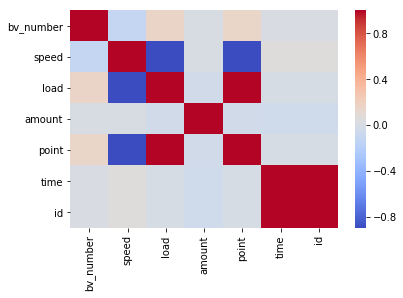

In [17]:
sns.heatmap(bbvdata.corr(), cmap="coolwarm")

По тепловой карте корреляции видно, что поля **load** и **point** являются равнозначными и имеют одинаковое поведение по отношению к выходным данным.

Видно, что корреляция поля **speed** по отношению к другим полям имеется(*amount*), но процент влияния меньше 40% и имеет смежную негативную корреляцию с **load** и **point**, так что имеет смысл не рассматривать это поле.

In [9]:
bbvdata = bbvdata.drop([
                    "point",
                    "speed"
                  ], axis=1)\
                  [[
                    "amount", 
                    "load",                                          
                    "bv_number", 
                    "date"
                  ]]
bbvdata.head()

,amount,load,bv_number,date
0,75,1,2,2016-07-09 16:11:59+06
1,255,8,2,2016-07-09 16:12:35+06
2,50,2,2,2016-07-09 16:13:10+06
3,118,1,2,2016-07-09 16:13:45+06
4,192,5,2,2016-07-09 16:14:21+06


### Дополнительные поля 

Так как загруженность на дорогах тесно связано с определенными периодами времени, имеет смысл разбить данные по месяцам, дням недели и по временным отрезкам. 

Мы можем агрегировать данные по временным отрезкам и поделить 24 часа на 144 сектора, где периодичностью изменений является 10 минут.

In [10]:
bbvdata["date"] = pd.to_datetime(bbvdata["date"])

In [11]:
bbvdata["Year"] = bbvdata["date"].apply(lambda d: d.year)
bbvdata["Hour"] = bbvdata["date"].apply(lambda d: d.hour)
bbvdata["Month"] = bbvdata["date"].apply(lambda d: d.month)
bbvdata["Chunk"] = bbvdata["date"].apply(lambda d: int((d.hour*60+d.minute)/10))
bbvdata["Day of the Week"] = bbvdata["date"].apply(lambda d: d.weekday()).map({
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
})

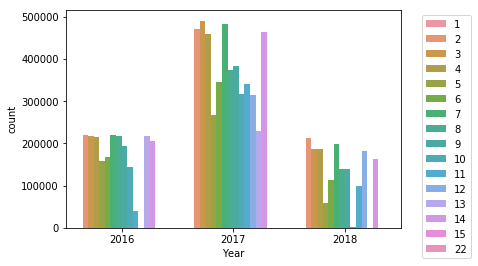

In [12]:
sns.countplot(x="Year", data=bbvdata, hue="bv_number")
plt.legend(bbox_to_anchor=(1.05, 1))

In [13]:
bbvdata["Year"].value_counts()

2017    4943524
2016    2219376
2018    1687425
Name: Year, dtype: int64

На графике хорошо прослеживается контраст. Количество данных за 2016 год небольшой, и имеет смысл не рассматривать эти данные, так как не так сильно влияют на обучение

In [14]:
bbvdata = bbvdata[bbvdata["Year"] > 2016]

### Слияние с погодой 

Так как погодные явления сильно влияют на движение на дорогах, используем погоду как параметры, где 
- **T** - температура
- **W1** - состояние погоды
- **RRR** - дождь
- **sss** - снег

In [56]:
weather = pd.read_excel("weather.xlsx")

In [57]:
weather = weather[['Местное время в Алматы', 'T', 'W1', 'RRR', 'sss']]

In [58]:
weather.head()

,Местное время в Алматы,T,W1,RRR,sss
0,24.05.2018 21:00,12.0,NaN,NaN,NaN
1,24.05.2018 18:00,14.5,NaN,NaN,NaN
2,24.05.2018 15:00,15.2,NaN,NaN,NaN
3,24.05.2018 12:00,13.2,NaN,11,NaN
4,24.05.2018 09:00,10.5,NaN,11,NaN


In [59]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
Местное время в Алматы    5473 non-null object
T                         5472 non-null float64
W1                        1488 non-null object
RRR                       821 non-null object
sss                       190 non-null object
dtypes: float64(1), object(4)
memory usage: 213.9+ KB


In [60]:
weather.isnull().sum()

Местное время в Алматы       0
T                            1
W1                        3985
RRR                       4652
sss                       5283
dtype: int64

In [61]:
weather = weather[~weather.isnull()["T"]]

In [62]:
weather_states = [
    'Туман или ледяной туман или сильная мгла.',
    'Снег или дождь со снегом.',
    'Ливень (ливни).',
    'Ливни или перемещающиеся осадки.',
    'Дождь.',
    'Осадки',
    'Явление, связанное с переносом ветром твердых частиц, видимость пониженная.',
    'Гроза (грозы) с осадками или без них.',
    'Морось.',
    'Облака покрывали более половины неба в течение всего соответствующего периода.',
    'Облака покрывали более половины неба в течение одной части соответствующего периода и половину или менее в течение другой части периода.',
    'Облака покрывали половину неба или менее в течение всего соответствующего периода.'
]

In [63]:
weather = weather.replace(np.nan, 0)

In [67]:
weather['W1'] = weather['W1'].apply(lambda w: 100-((weather_states.index(w) if type(w) != int else w) * 8))

In [69]:
weather['RRR'] = weather['RRR'].replace("Следы осадков", 1.0)
weather['sss'] = weather['sss'].replace("Менее 0.5", 0.5).replace("Снежный покров не постоянный.", 0.3)

In [124]:
weather = weather[pd.to_datetime(weather['Местное время в Алматы']).dt.year > 2016]
weather['date'] = pd.to_datetime(weather['Местное время в Алматы']).apply(lambda d: datetime(d.year, d.month, d.day, d.hour))

In [77]:
from datetime import datetime, timedelta
import time

In [115]:
quarters = [0,0,0,3,3,3,6,6,6,9,9,9,12,12,12,15,15,15,18,18,18,21,21,21]

In [119]:
bbvdata["date"] = bbvdata["date"].apply(lambda d: datetime(d.year, d.month, d.day, quarters[d.hour]))

In [125]:
bbvdata = bbvdata.merge(weather.drop("Местное время в Алматы",axis=1), on='date', how='inner')

In [129]:
bbvdata = bbvdata.drop(["date", "Hour", "Year"], axis=1)

In [135]:
bbvdata.head()

,amount,load,bv_number,Month,Chunk,Day of the Week,T,W1,RRR,sss
0,1,80,13,5,37,Tue,16.3,44,0.0,0.0
1,85,30,6,5,37,Tue,16.3,44,0.0,0.0
2,62,10,7,5,37,Tue,16.3,44,0.0,0.0
3,73,10,4,5,37,Tue,16.3,44,0.0,0.0
4,67,10,9,5,37,Tue,16.3,44,0.0,0.0


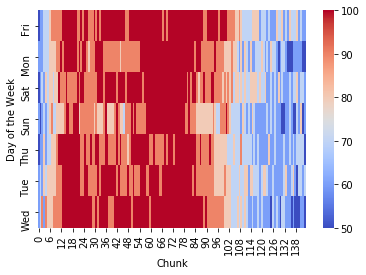

In [157]:
sns.heatmap(bbvdata.groupby(["Day of the Week","Chunk"]).max()["load"].unstack(),cmap="coolwarm")

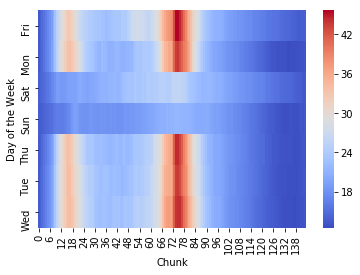

In [159]:
sns.heatmap(bbvdata.groupby(["Day of the Week","Chunk"]).mean()["load"].unstack(),cmap="coolwarm")

In [169]:
X = pd.get_dummies(bbvdata, columns=["bv_number", "Day of the Week"])

In [170]:
X.shape

(6224814, 28)

In [171]:
X.to_csv("preprocessed.csv")